In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import pearsonr
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score


STEP 1: GENERATE DATASET TO VALIDATE THE MODEL

a ) simulated_data: is a function where I create a dataset that should reseamble the RL experimental session. In the experiment there are 4 locations (midLeft, midRight, downLeft and downRight). The target appears equally often in all the 4 locations. But in one location participants receive high reward, i.e. 10 points and low reward, i.e. 1 point, in each of the other 3 locations, called "lowA", "lowB" and "lowC". The experiment is divided in 12 blocks of 100 trials each. In each block, a new spatial location (e.g. midLeft) become the new high-reward target location (e.g. maybe before the switch the high location was the downRight). Same for the low-reward target locations. That said, each of target  location (high, lowA, lowB and lowC) can be assigned 3 times to each of the spatial locations. For instance, the high-location (and low locations) can be assigned to the midLeft, midRight, etc, 3 times.  

In [2]:
#create a simulated dataset similar to the one I used for the RewSL experiment. And specifically to the SL session
def simulate_data(learning_rate, intercept, slope):
    n_switch = 12 #also called blocks
    switch_interval = 100 # rials in each block. Every 100 trials indeed we assigned a new spatial location 
    noise_std = 0.1 #nopise to add to the data
    Prev_val = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}  # probability associated to each spatial location at the begining, i.e. 25% each
    high_counts = {'midLeft': 0, 'midRight': 0, 'downLeft': 0, 'downRight': 0}  #track how often each location has been used for the role of high
    lowA_counts = {'midLeft': 0, 'midRight': 0, 'downLeft': 0, 'downRight': 0} #track how often each location has been used for the role of lowA
    lowB_counts = {'midLeft': 0, 'midRight': 0, 'downLeft': 0, 'downRight': 0} #track how often each location has been used for the role of lowB
    lowC_counts = {'midLeft': 0, 'midRight': 0, 'downLeft': 0, 'downRight': 0} #track how often each location has been used for the role of lowC
    reward = {} #dictionary to store target presence (1 or 0) per location for a given trial
    data = []
    
    for switch in range(n_switch): #at the begining of each switch, i.e. each block, i.e. after 100 trials.
        # Step 1: Finds all spatial locations that have not yet been the high-frequency location more than 3 times 
        valid_highs = []
        for loc in Prev_val.keys(): #i.e. locations = 'midLeft', 'midRight', 'downLeft', 'downRight'
            if high_counts[loc] < 3: #at the begining is alway <3 because I set each sptail locations to 0
                valid_highs.append(loc) 

        np.random.shuffle(valid_highs) #random order of the valid_high

        # Step 2: Find valid lowA, lowB, and lowC. As for high-frequency i WILL REPEAT THE PROCESS FOR EACH OF THE 3 LOWS
        found_valid_combination = False

        for high in valid_highs:
            # Remaining locations (not the high one)
            remaining_locs = []
            for loc in Prev_val.keys():
                if loc != high:
                    remaining_locs.append(loc)

            # Try all possible combinations of lowA, lowB, lowC
            for i in range(len(remaining_locs)):
                for j in range(len(remaining_locs)):
                    for k in range(len(remaining_locs)):
                        if i != j and i != k and j != k:
                            la = remaining_locs[i]
                            lb = remaining_locs[j]
                            lc = remaining_locs[k]

                            if (
                                lowA_counts[la] < 3 and
                                lowB_counts[lb] < 3 and
                                lowC_counts[lc] < 3
                            ):
                                lowA = la
                                lowB = lb
                                lowC = lc
                                found_valid_combination = True
                                break
                    if found_valid_combination:
                        break
                if found_valid_combination:
                    break

            if found_valid_combination:
                break

        if not found_valid_combination:
            raise ValueError("No valid low-role assignment found under 3-role constraints.")

        # Update counts for every locations
        high_counts[high] += 1
        lowA_counts[lowA] += 1
        lowB_counts[lowB] += 1
        lowC_counts[lowC] += 1

        # Set target frequency (again we are within each block, i.e. 100 trials)
        n_high = int(0.25 * switch_interval) 
        n_low = int(0.25 * switch_interval) 
        target_list = [high] * n_high + [lowA] * n_low + [lowB] * n_low + [lowC] * n_low #I create a list with 100 values of target
        np.random.shuffle(target_list)  #I shuffle the list in order to randomize everything
        #simulate correct responses
        n_corr = int(0.75 * switch_interval) 
        n_incorr = int(0.25 * switch_interval)     
        resp_list = [1] * n_corr + [0] * n_incorr  
        np.random.shuffle(resp_list) 
        
        
        for trial in range(switch_interval): #for each trial in the current block
            absolute_trial = trial + switch * switch_interval  #this is just a variable to indicate the trial count
            t_pos = target_list[trial] #I create variable t_pos and I assign a value from target-list (that was high, lowA, lowB or lowC)
            key_resp = resp_list[trial]

            #Here I just wanted to create a variable named t_frequency that I can then save in the excell file.
            if t_pos == high:
                t_frequency = "high"
            elif t_pos == lowA:
                t_frequency = "lowA"
            elif t_pos == lowB:
                t_frequency = "lowB"
            elif t_pos == lowC:
                t_frequency = "lowC"
            
            #set reward
            for loc in Prev_val.keys():
                if key_resp == 1:
                    if loc == t_pos and t_pos == high:
                        reward[loc] = 100
                    elif loc == t_pos and t_pos != high:
                        reward[loc] = 1
                    else:
                        reward[loc] = 0
                elif key_resp == 0:
                    reward[loc] = 0

            # Simulate RSs
            RS = intercept + slope * Prev_val[t_pos] + np.random.normal(0, noise_std)
            
            # Update probabilities for each sptail location
            for loc in Prev_val.keys():
                Prev_val[loc] += learning_rate * (reward[loc] - Prev_val[loc])
                Prev_val[loc] = min(max(Prev_val[loc], 0.0001), 0.9999) 

            data.append([absolute_trial, switch, t_pos, t_frequency, RS, key_resp] + [reward[loc] for loc in Prev_val.keys()] + [Prev_val[loc] for loc in Prev_val.keys()])

    # Creazione del DataFrame e salvataggio su CSV
    columns = ['Trial', "switch", 't_pos', 't_frequency', 'resp_speed', 'Resp'] + [f'Reward_{loc}' for loc in Prev_val.keys()] + [f'Pval_{loc}' for loc in Prev_val.keys()]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv("attentionalRL_task.csv", index=False)
    
simulate_data(learning_rate = 0.8, intercept = 4, slope = 2.5)


b) Log_likelihood: with this function I validate my model and see if I can correctly estimate the 3 parametrs (in this case: learning rate 0.8, slope 4 and intercept 2.5) I used to create the simulated_data
    
    minimize: is the function I use to actually validate the model. It seems that works since I get x: [ 8.020e-01  4.002e+00  2.504e+00]

In [3]:
def log_likelihood(parameters, file_name):
    learning_rate, intercept, slope = parameters 
    Prev_val = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}  # Probabilità iniziali
    reward = {}
    df = pd.read_csv(file_name)
    log_likelihood = 0
      
    for i in range(len(df)):
        current_targetPos = df.loc[i, 't_pos']
        current_frequency = df.loc[i, 't_frequency']
        current_resp = df.loc[i, 'Resp']
        
        # Compute reward
        for loc in Prev_val.keys():
            if current_resp == 1:
                if loc == current_targetPos and current_frequency == "high":
                    reward[loc] = 100
                elif loc == current_targetPos and current_frequency != "high":
                    reward[loc] = 1
                else:
                    reward[loc] = 0
            elif current_resp == 0:
                reward[loc] = 0

        #calculate RS
        predict_RS = intercept + slope * Prev_val[current_targetPos]
        
        real_RS = df.loc[i, 'resp_speed']

        #Accumulate error
        error = real_RS - predict_RS
        log_likelihood += -error ** 2
        
        # Update probabilities
        for loc in Prev_val.keys():
            Prev_val[loc] += learning_rate * (reward[loc] - Prev_val[loc])
            Prev_val[loc] = min(max(Prev_val[loc], 0.0001), 0.9999) 
        
    
    return -log_likelihood 

In [4]:
#Optimize parameters
init_params = [0.2, 1.9, 1]  # Initial guesses
bounds = [(0.0001, 1), (-10, 10), (-10, 10)]  # reasonable bounds

result = minimize(log_likelihood, init_params, args=("attentionalRL_task.csv",), bounds=bounds)
print(result)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 12.094699897072378
        x: [ 8.020e-01  4.002e+00  2.504e+00]
      nit: 14
      jac: [ 5.951e-05  6.857e-05  4.796e-05]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


STEP 2: USE RW MODEL TO SIMULATED RS

a) Since the model seems to work, I use the estimated parametrs to simulate RS on the dataset I created

In [10]:
def simulate_RS_on_generatedData(learning_rate, intercept, slope, file_name):
    df = pd.read_csv(file_name)
    noise_std=0.1
    Prev_val = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}
    reward = {}
    simulated_RS = [] 

    for i in range(len(df)):
        current_targetPos = df.loc[i, 't_pos']
        current_frequency = df.loc[i, 't_frequency']
        current_resp = df.loc[i, 'Resp']
        
        # Compute reward
        for loc in Prev_val.keys():
            if current_resp == 1:
                if loc == current_targetPos and current_frequency == "high":
                    reward[loc] = 100
                elif loc == current_targetPos and current_frequency != "high":
                    reward[loc] = 1
                else:
                    reward[loc] = 0
            elif current_resp == 0:
                reward[loc] = 0

                
        # Simulated RS without noise
        RS = intercept + slope * Prev_val[current_targetPos] + np.random.normal(0, noise_std)
        simulated_RS.append(RS)

        # Update probabilities
        for loc in Prev_val:
            Prev_val[loc] += learning_rate * (reward[loc] - Prev_val[loc])
            Prev_val[loc] = min(max(Prev_val[loc], 0.0001), 0.9999)

    # Add the simulated RS to the DataFrame
    df["simulated_RS"] = simulated_RS
    df.to_csv("attentionalRL_task_with_RSstimated.csv", index=False)
    return df

In [11]:
learning_rate_est, intercept_est, slope_est = result.x
df_with_sim = simulate_RS_on_generatedData(learning_rate_est, intercept_est, slope_est, "attentionalRL_task.csv")
#print(df_with_sim.head())

b) I plot and calculate the correlation between real (generted) RS and simulated RS.

It seems to work since correlation is around 0.9

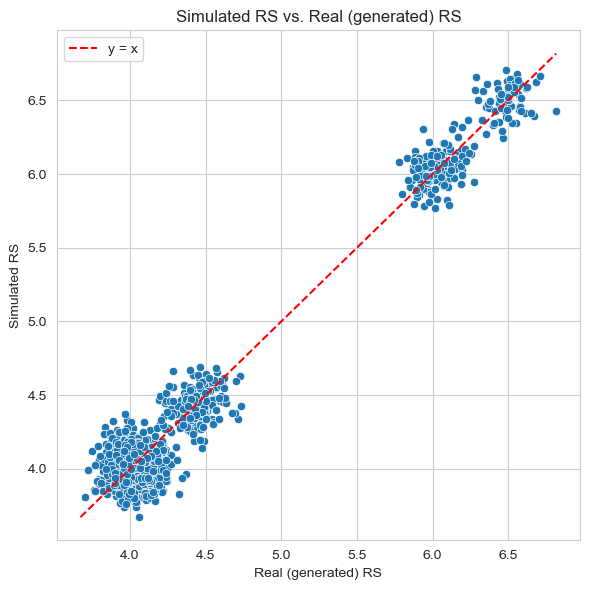

R² tra RS reale e simulato: 0.969


In [12]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_with_sim, x='resp_speed', y='simulated_RS')

# Diagonal reference line (y = x)
min_val = min(df_with_sim['resp_speed'].min(), df_with_sim['simulated_RS'].min())
max_val = max(df_with_sim['resp_speed'].max(), df_with_sim['simulated_RS'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('Real (generated) RS')
plt.ylabel('Simulated RS')
plt.title(f'Simulated RS vs. Real (generated) RS')
plt.legend()
plt.tight_layout()
plt.show()

r2 = r2_score(df_with_sim["resp_speed"], df_with_sim["simulated_RS"])
print(f"R² tra RS reale e simulato: {r2:.3f}")

STEP 3: DOUBLE CHECK 

The model seems to work, but to be sure I firstly create 20 simulated dataset with 20 random values of parameters. Run the estimation 10 times for each simulated dataset and take the best one. Then perform the correlation between the true parameters (that we choose randomly) and the estimated.

In [13]:
# Generate true parameter values
true_learning_rate = np.random.uniform(0.1, 0.99, 20) 
true_intercept = np.random.uniform(0.1, 10, 20)
true_slope = np.random.uniform(0.1, 10, 20)  # Match length to 30

# Lists to store estimated parameters
estimated_learning_rate = []
estimated_intercept = []
estimated_slope = []

for lr, interc, s in zip(true_learning_rate, true_intercept, true_slope): 
    simulate_data(learning_rate=lr, intercept=interc, slope=s)  # Simulate dataset
    
    best_result = None
    best_log_likelihood = float('inf')  # Start with a large value
    
    # Run estimation 10 times
    for _ in range(10):  
        random_init_params = [np.random.uniform(0.1, 0.99), np.random.uniform(0.1, 15), np.random.uniform(0.1, 15)]  #random initial parameters for learning rate, intercept and Slope
    
        result = minimize(log_likelihood, random_init_params, args=("attentionalRL_task.csv",), 
                          bounds=[(0, 10), (-100, 100), (-100, 100)])
        
        if result.success == True: 
            if result.fun < best_log_likelihood:
                best_log_likelihood = result.fun
                best_result = result

    if best_result:
        estimated_learning_rate.append(best_result.x[0])
        estimated_intercept.append(best_result.x[1])
        estimated_slope.append(best_result.x[2])
    else:
        # If no successful optimization, store NaN
        estimated_learning_rate.append(np.nan)
        estimated_intercept.append(np.nan)
        estimated_slope.append(np.nan)

# Convert results into a DataFrame for analysis
df_results = pd.DataFrame({
    "True_LR": true_learning_rate,
    "Est_LR": estimated_learning_rate,
    "True_Intercept": true_intercept,
    "Est_Intercept": estimated_intercept,
    "True_Slope": true_slope,
    "Est_Slope": estimated_slope
})


print(df_results)
corr_matrix = df_results.corr()
print(corr_matrix)

     True_LR    Est_LR  True_Intercept  Est_Intercept  True_Slope  Est_Slope
0   0.670271  0.664804        1.856930       1.859132    3.081575   3.096090
1   0.150209  0.151031        4.113598       4.110947    4.530203   4.540852
2   0.748373  0.748116        1.415869       1.421585    8.853329   8.840703
3   0.390123  0.391536        4.657571       4.660425    0.881344   0.876701
4   0.413847  0.413442        5.573689       5.577625    0.772467   0.762591
5   0.149790  0.149445        8.982622       8.981501    2.245336   2.248555
6   0.480666  0.480906        0.995488       0.997930    8.793113   8.805277
7   0.970697  0.968911        3.135712       3.139491    1.134175   1.130348
8   0.743835  0.742208        1.694519       1.686177    8.448914   8.473021
9   0.328629  0.328497        4.781100       4.781003    1.963917   1.957609
10  0.146093  0.146110        0.647106       0.647449    9.442594   9.429618
11  0.784445  0.784803        5.895012       5.896948    8.872481   8.876592

b) Correlation between the true parameters (that we choose randomly) and the estimated.

Correlation between simulated and estimated learning rate: 1.00
Correlation between simulated and estimated intercept: 1.00
Correlation between simulated and estimated slopes: 1.00


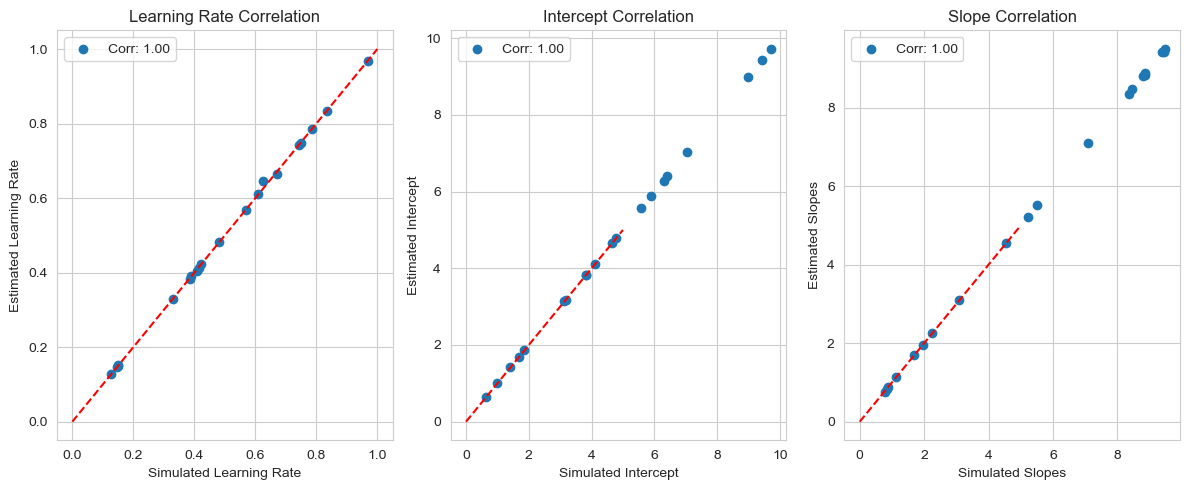

In [14]:
# Calculate correlation for learning rates
corr_lr, _ = pearsonr(true_learning_rate, estimated_learning_rate)
print(f'Correlation between simulated and estimated learning rate: {corr_lr:.2f}')

corr_intercept, _ = pearsonr(true_intercept, estimated_intercept)
print(f'Correlation between simulated and estimated intercept: {corr_intercept:.2f}')

corr_slope, _ = pearsonr(true_slope, estimated_slope)
print(f'Correlation between simulated and estimated slopes: {corr_slope:.2f}')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 2 columns

# Plot Learning Rate Correlation
axes[0].scatter(true_learning_rate, estimated_learning_rate, label=f'Corr: {corr_lr:.2f}')
axes[0].plot([0, 1], [0, 1], 'r--')  # Reference diagonal line
axes[0].set_xlabel('Simulated Learning Rate')
axes[0].set_ylabel('Estimated Learning Rate')
axes[0].set_title('Learning Rate Correlation')
axes[0].legend()

# Plot intercept LOW Correlation
axes[1].scatter(true_intercept, estimated_intercept, label=f'Corr: {corr_intercept:.2f}')
axes[1].plot([0, 5], [0, 5], 'r--')  # Reference diagonal line
axes[1].set_xlabel('Simulated Intercept')
axes[1].set_ylabel('Estimated Intercept')
axes[1].set_title('Intercept Correlation')
axes[1].legend()

# Plot Slope Correlation
axes[2].scatter(true_slope, estimated_slope, label=f'Corr: {corr_slope:.2f}')
axes[2].plot([0, 5], [0, 5], 'r--')  # Reference diagonal line
axes[2].set_xlabel('Simulated Slopes')
axes[2].set_ylabel('Estimated Slopes')
axes[2].set_title('Slope Correlation')
axes[2].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()